In [2]:
%pip install -q datasets transformers

In [3]:
from datasets import load_dataset

ds = load_dataset("martingrzzler/kanjis2radicals")

  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
ds['train'].features

{'kanji_image': Image(decode=True, id=None),
 'meta': {'id': Value(dtype='int32', id=None),
  'characters': Value(dtype='string', id=None),
  'meanings': Value(dtype='string', id=None),
  'radicals': Sequence(feature={'characters': Value(dtype='string', id=None), 'id': Value(dtype='int32', id=None), 'slug': Value(dtype='string', id=None)}, length=-1, id=None)}}

{'kanji_image': <PIL.PngImagePlugin.PngImageFile image mode=L size=64x64 at 0x7FBA8C9F8DC0>, 'meta': {'id': 2083, 'characters': '丈', 'meanings': 'Height,Ten Feet', 'radicals': {'characters': ['丈'], 'id': [408], 'slug': ['height']}}}


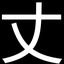

In [5]:
idx = 5
print(ds['train'][idx])
ds['train'][idx]['kanji_image']

In [5]:
import numpy as np
radical_range = set(range(1,440))
radical_ids = set()

for meta in ds['train']['meta']:
    for id in meta['radicals']['id']:
        if id <= 439:
            radical_ids.add(id)

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [6]:
missing_radical_ids = radical_range - radical_ids

In [7]:
missing_radical_ids

{58, 59, 70, 133, 225, 316, 335, 375, 386, 401}

In [4]:
radical_ds = load_dataset("martingrzzler/radicals")

  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
radical_ids = set()
for meta in radical_ds['train']['meta']:
    radical_ids.add(meta['id'])

unique_radical_ids = sorted(list(radical_ids))
num_classes = len(unique_radical_ids)
radical_id_to_index = {radical_id: idx for idx, radical_id in enumerate(unique_radical_ids)}

In [6]:
num_classes

439

In [7]:
def filter_unsupported_radicals(example):
    for id in example['meta']['radicals']['id']:
        if id > 439:
            return False
    return True

In [8]:
filtered_ds = ds['train'].filter(filter_unsupported_radicals)
filtered_ds = filtered_ds.map(lambda example: {'kanji_id': example['meta']['id']})

In [9]:
filtered_ds

Dataset({
    features: ['kanji_image', 'meta', 'kanji_id'],
    num_rows: 1750
})

In [10]:
filtered_ds = filtered_ds.sort(['kanji_id'])

In [11]:
import numpy as np

def one_hot_encode(example):
    radical_indices = [radical_id_to_index[id] for id in example["meta"]["radicals"]["id"]]
    one_hot = np.zeros(len(unique_radical_ids))
    one_hot[radical_indices] = 1
    return {"labels": one_hot}

In [12]:
ds_one_hot = filtered_ds.map(one_hot_encode)

In [13]:
sum(ds_one_hot[1000]['labels'])

2.0

In [14]:
ds_train = ds_one_hot.remove_columns(["meta"])

In [98]:
import random

def random_rotate_image(image):
    angle = random.choice([0, 90, 180, 270])
    return image.rotate(angle)

In [26]:
from datasets import Dataset
from PIL import ImageChops
augmented = {
    'kanji_image': [],
    'labels': []
}

shifts = [-1, 0, 1]
angles = [1,0,-1]

for i in range(len(ds_train)):
    example = ds_train[i].copy()
    for i in range(len(angles)):
        for j in range(len(shifts)):
            for k in range(len(shifts)):
                augmented_example = example.copy()
                augmented_example['kanji_image'] = example['kanji_image'].rotate(angles[i])
                augmented_example['kanji_image'] = ImageChops.offset(augmented_example['kanji_image'], shifts[j], shifts[k])

                augmented['kanji_image'].append(augmented_example['kanji_image'])
                augmented['labels'].append(augmented_example['labels'])


In [27]:
len(augmented['labels'])

47250

In [30]:
import pandas as pd
rotated_ds = Dataset.from_dict(augmented)

In [40]:
rotated_ds.set_format(type='torch', columns=['kanji_image', 'labels'])
# ds_train.set_format(type='torch', columns=['kanji_image', 'labels'])

In [41]:
normalized_ds = rotated_ds.map(lambda example: {'kanji_image': example['kanji_image'].unsqueeze(0) / 255.0})

Map:   0%|          | 0/47250 [00:00<?, ? examples/s]

In [42]:
splits = normalized_ds.train_test_split(test_size=0.1, shuffle=True)

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, num_classes):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.conv3 = nn.Conv2d(64, 128, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(4608, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.fc3 = nn.Linear(num_classes, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        output = F.sigmoid(x)
        return output

model = Net(num_classes)

In [44]:
import torch

best_radical_state_dict = torch.load('v2_best.pt')
new_state_dict = model.state_dict()

for key in best_radical_state_dict:
    if key.startswith('fc3'):
        continue
    new_state_dict[key] = best_radical_state_dict[key]


In [45]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [52]:
# freeze pretrained layers
# for param in model.parameters():
#     param.requires_grad = True

# # unfreeze last layer
# for param in model.fc3.parameters():
#     param.requires_grad = True

In [57]:
from torch.utils.data import DataLoader

batch_size = 1

splits.set_format(type='torch', columns=['kanji_image', 'labels'])
train_loader = DataLoader(splits['train'], batch_size=batch_size, shuffle=True)
test_loader = DataLoader(splits['test'], batch_size=batch_size, shuffle=False)

In [63]:
import torch
import torch.nn as nn

loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [48]:
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4608, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=439, bias=True)
  (fc3): Linear(in_features=439, out_features=439, bias=True)
)

In [49]:
train_loader.dataset[0]['kanji_image'].shape

torch.Size([1, 64, 64])

In [64]:
losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()
    for idx, batch in enumerate(train_loader):
        images, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        losses.append(loss.item())
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        if idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Step {idx+1}/{len(train_loader)}, Loss: {loss.item()}")

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for batch in test_loader:
            images, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            test_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader)}, Val Loss: {test_loss/len(test_loader)}")

Epoch 1/10, Step 1/42525, Loss: 0.019255271181464195
Epoch 1/10, Step 101/42525, Loss: 0.30187925696372986
Epoch 1/10, Step 201/42525, Loss: 0.15891627967357635
Epoch 1/10, Step 301/42525, Loss: 0.10406088083982468
Epoch 1/10, Step 401/42525, Loss: 0.08308565616607666
Epoch 1/10, Step 501/42525, Loss: 0.06184297800064087
Epoch 1/10, Step 601/42525, Loss: 0.05882120132446289
Epoch 1/10, Step 701/42525, Loss: 0.04626448079943657
Epoch 1/10, Step 801/42525, Loss: 0.055863551795482635
Epoch 1/10, Step 901/42525, Loss: 0.03869802877306938
Epoch 1/10, Step 1001/42525, Loss: 0.02929537557065487
Epoch 1/10, Step 1101/42525, Loss: 0.044462382793426514
Epoch 1/10, Step 1201/42525, Loss: 0.03418833762407303
Epoch 1/10, Step 1301/42525, Loss: 0.024728942662477493
Epoch 1/10, Step 1401/42525, Loss: 0.02763400226831436
Epoch 1/10, Step 1501/42525, Loss: 0.022351223975419998
Epoch 1/10, Step 1601/42525, Loss: 0.038786038756370544
Epoch 1/10, Step 1701/42525, Loss: 0.0316145233809948
Epoch 1/10, Step 

KeyboardInterrupt: 

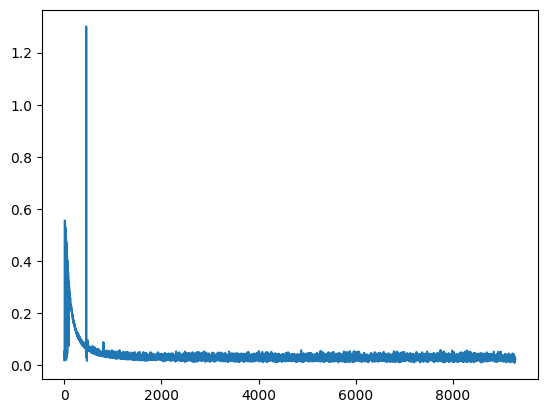

In [65]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.show()

In [61]:
def predict(model, image):
    model.eval()
    with torch.no_grad():
        image = image.unsqueeze(0).unsqueeze(0).to(device) / 255.0
        output = model(image)
        return output

In [66]:
sorted(predict(model, ds_train[267]['kanji_image']).flatten().cpu().numpy())[::-1]

[0.07511428,
 0.06466022,
 0.061889514,
 0.056116693,
 0.04428023,
 0.036519904,
 0.034743555,
 0.03282588,
 0.031234365,
 0.03119858,
 0.030523451,
 0.027594518,
 0.026329597,
 0.026250424,
 0.025245031,
 0.024656028,
 0.024383618,
 0.023516612,
 0.023387259,
 0.022799455,
 0.020749139,
 0.019664114,
 0.01960701,
 0.019384263,
 0.019304773,
 0.018858993,
 0.017585456,
 0.016926209,
 0.016667299,
 0.016540553,
 0.016273307,
 0.015898848,
 0.015700983,
 0.014845137,
 0.014770793,
 0.014720658,
 0.01444665,
 0.014048256,
 0.013932383,
 0.013909401,
 0.013859971,
 0.013854356,
 0.012795721,
 0.012346236,
 0.012330454,
 0.012224214,
 0.011899706,
 0.011467288,
 0.011086742,
 0.010979002,
 0.010852666,
 0.010668982,
 0.010631455,
 0.010454154,
 0.01019984,
 0.00982904,
 0.0097193895,
 0.0096685225,
 0.009593713,
 0.009163719,
 0.008837855,
 0.008783895,
 0.008391901,
 0.008343823,
 0.008328512,
 0.008302848,
 0.00826313,
 0.0078476835,
 0.0077688205,
 0.007695461,
 0.0075067827,
 0.00748352

In [115]:
for i, ex in enumerate(filtered_ds):
    if ex['meta']['id'] == 736:
        print(i)

267


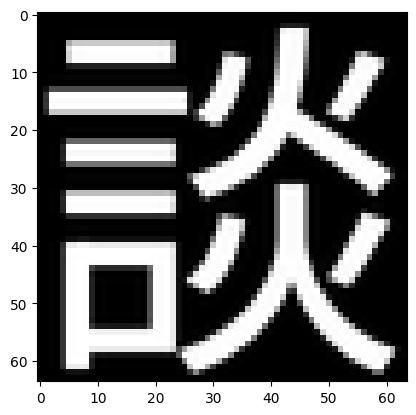

In [42]:
import matplotlib.pyplot as plt

plt.imshow(ds_train[267]['kanji_image'], cmap='gray')

In [46]:
import numpy as np
from sklearn.metrics import f1_score

threshold = 0.1

model.eval()
all_ground_truth = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        image, labels = batch['kanji_image'].to(device), batch['labels'].to(device)
        outputs = model(image)
        bool_outputs = (outputs > threshold).cpu().numpy()
        all_predictions.extend(bool_outputs)
        
        all_ground_truth.extend(labels.cpu().numpy())

y_true = np.array(all_ground_truth)
y_pred = np.array(all_predictions)

# Calculate F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print("F1 Score:", f1)

for i in range(10):
    print("Ground Truth:", np.where(y_true[i] == 1)[0])
    print("Predictions:", np.where(y_pred[i] == 1)[0])
    print()

F1 Score: 0.0
Ground Truth: [102 214]
Predictions: []

Ground Truth: [101 125 127]
Predictions: []

Ground Truth: [ 51 235]
Predictions: []

Ground Truth: [42 43]
Predictions: []

Ground Truth: [183 377]
Predictions: []

Ground Truth: [ 62 194]
Predictions: []

Ground Truth: [122 425]
Predictions: []

Ground Truth: [16 61 97]
Predictions: []

Ground Truth: [ 15 413]
Predictions: []

Ground Truth: [102 393]
Predictions: []



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
